In [3]:
import xarray as xr
from  cartopy import crs as ccrs
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib import rc

rc("font", **{"family": "Times"})
rc("text", usetex=True)
plt.rcParams['figure.dpi']= 100

latitudes = xr.DataArray(np.load('latitude.npy'), dims = ('y', 'x'))
longitudes = xr.DataArray(np.load('longitude.npy'), dims = ('y', 'x'))
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)

test_frames = xr.open_dataset("test.nc").pr.values.reshape(-1, 64, 64)
sample_frames = torch.load("samples.pt", map_location="cpu").numpy().reshape(-1, 64, 64)

test_cell_means = np.mean(test_frames, axis=(0,)).reshape(1, 64, 64)
sample_cell_means = np.mean(sample_frames, axis=(0,)).reshape(1, 64, 64)

diff_means = (sample_cell_means - test_cell_means) / test_cell_means

Mean absolute difference in cell means:  0.036294207


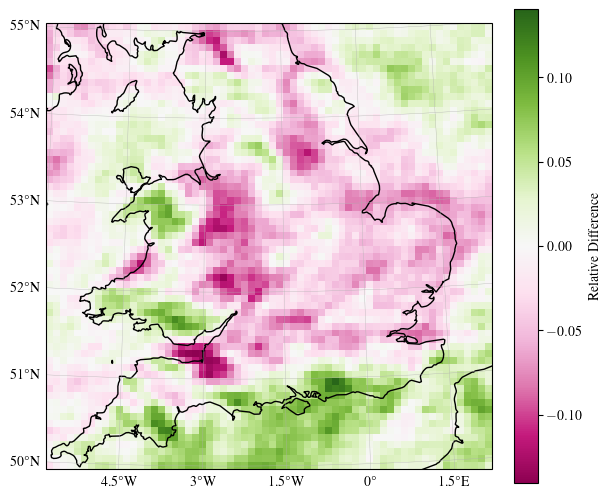

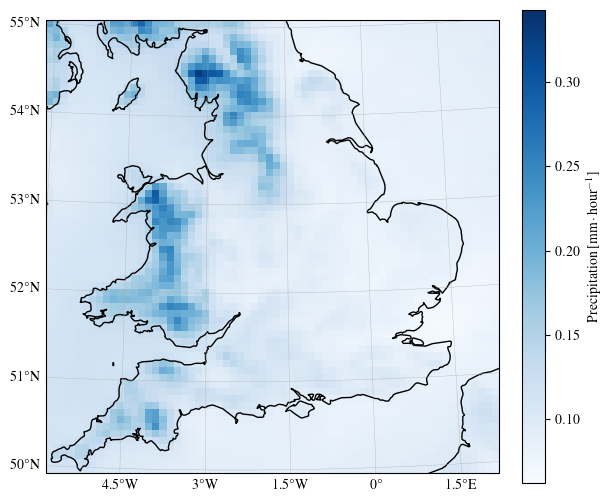

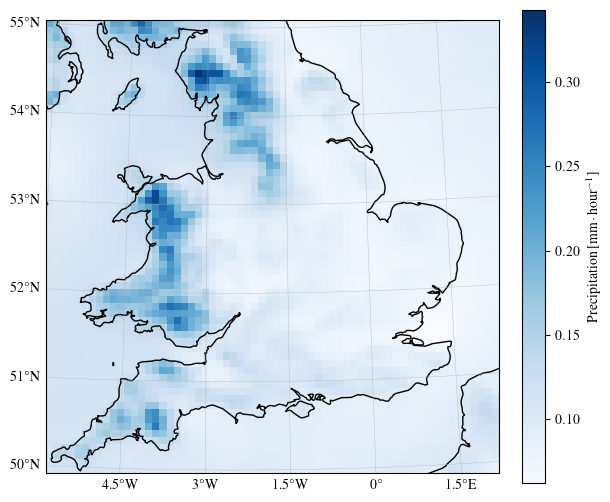

In [4]:
test_sample_min = min(np.min(test_cell_means), np.min(sample_cell_means))
test_sample_max = max(np.max(test_cell_means), np.max(sample_cell_means))

diff_abs_max = max(np.abs(np.min(diff_means)), np.abs(np.max(diff_means)))

def plot_means_diff(da, type):
    if type == "means":
        vmin = test_sample_min
        vmax = test_sample_max
        label = "Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]"
        cmap = "Blues"
    elif type == "diff":
        vmin = -diff_abs_max
        vmax = diff_abs_max
        label = "Relative Difference"
        cmap = "PiYG"
    _, ax = plt.subplots(
        figsize=(6, 6), 
        subplot_kw={'projection': cp_model_rotated_pole},
        layout="constrained",
    )
    da.isel(time=0).plot.pcolormesh(
        ax=ax,
        x="longitude",
        y="latitude",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={
            "shrink": 0.8,
            "label": label,
        }
    )
    ax.gridlines(linewidth = 0.25, draw_labels={"bottom": "x", "left": "y"}, x_inline=False, y_inline=False)
    ax.coastlines(resolution='10m')
    plt.plot()

diff_da = xr.DataArray(diff_means, dims=('time', 'y', 'x'), coords={'latitude': latitudes, 'longitude': longitudes})
test_da = xr.DataArray(test_cell_means, dims=('time', 'y', 'x'), coords={'latitude': latitudes, 'longitude': longitudes})
sample_da = xr.DataArray(sample_cell_means, dims=('time', 'y', 'x'), coords={'latitude': latitudes, 'longitude': longitudes})

print("Mean absolute difference in cell means: ", np.mean(np.abs(diff_means)))

plot_means_diff(diff_da, type="diff")
plot_means_diff(test_da, type="means")
plot_means_diff(sample_da, type="means")